In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import lightgbm as lgb
import shap
import re


In [2]:
import sys
sys.path.insert(0, '../milestone-04')
from utils import load_from_csv

import timeseries_utils
import utils_lgbm

In [3]:
# Import the tables of the data set as dataframes.
# Choose random or uniform sampling
uniform = False

if not uniform:
    DATA_DIR = '../milestone-04/data' 

    # You can use the nrows=X argument in pd.read_csv to truncate your data
    users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col=0)
    events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col=0)
    subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)
    mastery_df = load_from_csv('../milestone-04/dataframe.csv')
else:
    DATA_DIR = './data_uniform' 
    users = pd.read_csv('{}/users_uniform_sample.csv'.format(DATA_DIR),index_col=1)
    events = pd.read_csv('{}/events_uniform_sample.csv'.format(DATA_DIR), index_col=1)
    subtasks = pd.read_csv('{}/subtasks_uniform_sample.csv'.format(DATA_DIR), index_col=1)
    mastery_df = load_from_csv('dataframe_uniform.csv')

In [4]:
index = ['event_id','user_id']
protected_features = ['country']
cat_features = ['mode_event', 'game_name','number_range', 'type_subtask'] #,'skill_id'
cat_features_withnulls = [ 'destination', 'multiplier','operator','representation', 'solutionRepresentation', 'solveMode']
features_to_one_hot = cat_features + cat_features_withnulls
date_features = ['date','Year', 'Week', 'Day','week','year_week']
bool_feature = ['correct']

In [5]:
full_df = timeseries_utils.create_timeseries(users, events, subtasks)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
full_df = full_df[index + protected_features + features_to_one_hot + date_features + bool_feature]

In [7]:
# Create a feature that represents the student's overall cumulative accuracy per game
cumulative_percent_correct = full_df.groupby(['user_id','game_name'],sort=False)['correct'].expanding(1).mean().reset_index().drop(columns=['user_id','game_name']).rename(columns={'correct':'cumulative_percent_correct'})
full_df = full_df.merge(cumulative_percent_correct, left_index=True, right_on='level_2', how='left')

# Create a feature that represent's a games's overall cumulative correctness for all students
df_skills_mean = full_df.groupby(["game_name", "year_week"]).mean()
df_skills_mean["game_cumulative_percent_correct"] = df_skills_mean['correct'].expanding(1).mean()
df_skills_mean = df_skills_mean.reset_index()[["game_name","year_week","game_cumulative_percent_correct"]]
full_df = full_df.merge(df_skills_mean, on=["game_name","year_week"], how='left')

In [20]:
final_df = mastery_df.reset_index().copy()
final_df = final_df[final_df['mastery_level'] != 0]

In [21]:
final_df = final_df.merge(full_df.groupby(['user_id','week','game_name'])['cumulative_percent_correct'].last(), on=['user_id','week','game_name'], how='left')
final_df = final_df.fillna(method='ffill')

In [22]:
final_df = final_df.merge(full_df.groupby(['user_id','week','game_name'])['game_cumulative_percent_correct'].last(), on=['user_id','week','game_name'], how='left')
final_df = final_df.fillna(method='ffill')

In [23]:
for feat in features_to_one_hot:
    one_hot_df = pd.get_dummies(full_df[feat], prefix=feat).join(full_df[['user_id','week','game_name']]).groupby(['user_id','week','game_name']).sum()
    final_df = final_df.merge(one_hot_df, on=['user_id','week','game_name'], how='left')
final_df = final_df.fillna(0)

In [24]:
final_df = final_df.merge(users['country'], on='user_id')

In [25]:
final_df = final_df.drop(columns=["mastery_level_diff"])
df = final_df

In [26]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', str(x)))

In [27]:
# LGBM only accepts int, bool and float
for col in protected_features + ["game_name"]:
    # Convert categories into ints
    df[col] = df[col].astype('category')
df['week'] = df['week'].astype('int32')

In [28]:
target_col = "mastery_level"
all_cols = list(df.columns)
all_cols.remove(target_col)


In [29]:
features = all_cols
target_feature = [target_col]

In [33]:
cat_features = protected_features + ["game_name", "user_id"]

In [34]:
train = df.query('user_id < 600')[features]
y_train = df.query('user_id < 600')[target_feature]

val = df.query('600 <= user_id < 800')[features]
y_val = df.query('600 <= user_id < 800')[target_feature]

test = df.query('user_id >= 800')[features]
y_test = df.query('user_id >= 800')[target_feature]

train["user_id"] = train["user_id"].astype('category')
val["user_id"] = val["user_id"].astype('category')
test["user_id"] = test["user_id"].astype('category')


lgb_train = lgb.Dataset(train, y_train, categorical_feature = cat_features, free_raw_data=False)
lgb_eval = lgb.Dataset(val, y_val, categorical_feature = cat_features, free_raw_data=False)
lgb_test = lgb.Dataset(test, y_test, categorical_feature = cat_features, free_raw_data=False, reference=lgb_train)

In [18]:
# cutoff = 10

In [19]:
# train = df.query(f'week < {cutoff}')[features]
# y_train = df.query(f'week < {cutoff}')[target_feature]

# val = df.query(f'{cutoff} <= week < {cutoff+10}')[features]
# y_val = df.query(f'{cutoff} <= week < {cutoff+10}')[target_feature]

# test = df.query(f'week > {cutoff}')[features]
# y_test = df.query(f'week > {cutoff}')[target_feature]

# lgb_train = lgb.Dataset(train, y_train, categorical_feature = protected_features, free_raw_data=False)
# lgb_eval = lgb.Dataset(val, y_val, categorical_feature = protected_features, free_raw_data=False)
# lgb_test = lgb.Dataset(test, y_test, categorical_feature = protected_features, free_raw_data=False, reference=lgb_train)

# # lgb_train, lgb_eval, lgb_test

In [35]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

In [36]:
params = {'objective': 'regression',
      'metric': ['mse','rmse','mape'],
      'seed': 0,
      'learning_rate': 0.1, #default
      "boosting_type": "gbdt" #default
      # 'num_leaves': 200,
      # 'feature_fraction': 0.75,
      # 'bagging_freq': 10,
      # 'bagging_fraction': 0.80
     }
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8,
    keep_training_booster=True,
    feval=lgbm_smape
)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.389473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1509
[LightGBM] [Info] Number of data points in the train set: 54860, number of used features: 78


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 0.170088
Training until validation scores don't improve for 8 rounds
Early stopping, best iteration is:
[33]	training's l2: 0.00325069	training's rmse: 0.0570148	training's mape: 0.0359282	training's SMAPE: 31.9954	valid_1's l2: 0.0144522	valid_1's rmse: 0.120217	valid_1's mape: 0.0746658	valid_1's SMAPE: 47.2909


In [37]:
overall_mape = model.eval(lgb_test, 'test')
print(overall_mape)
# print(f"Overall MAPE for test data is {overall_mape[0][2]}")

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[('test', 'l2', 0.016041856858561205, False), ('test', 'rmse', 0.12665645210000637, False), ('test', 'mape', 0.07873814702594205, False)]


In [ ]:
# test['cumulative_percent_correct'] = np.NaN
# test['game_cumulative_percent_correct'] = np.NaN

In [ ]:
lgb_test = lgb.Dataset(test, y_test, categorical_feature = protected_features, free_raw_data=False, reference=lgb_train)


In [ ]:
model.eval(lgb_test, 'mape')

In [ ]:
y_pred_test = model.predict(test, num_iteration=model.best_iteration)


In [ ]:
smape(y_pred_test, 

In [ ]:
pred_df = test.copy()
pred_df['mastery_pred'] = y_pred_test
pred_df['mastery_level'] = y_test

In [ ]:
u_id = 8

In [ ]:
# sns.lineplot(
#     data=pred_df.query(f'user_id =={u_id}'),
#     x="week",
#     y="mastery_level",
#     hue='game_name',
#     legend=None
# )
sns.lineplot(
    data=df.query(f'user_id =={u_id}'),
    x="week",
    y="mastery_level",
    hue="game_name",
    legend=None
)
sns.scatterplot(
    data=pred_df.query(f'user_id =={u_id}'),
    x="week",
    y="mastery_pred",
    hue='game_name',
    legend=None
)

plt.title(f"Mastery level predictions after {cutoff} weeks for student {u_id}")
plt.savefig(f"mastery_{cutoff}_weeks_user_{u_id}.png")

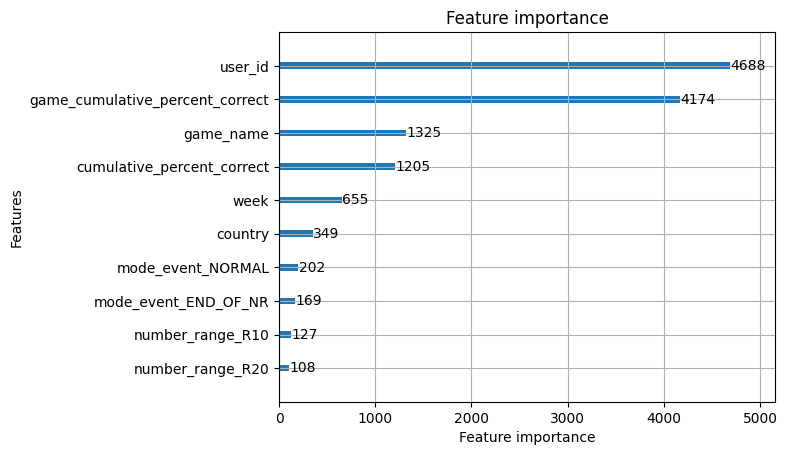

In [310]:
lgb.plot_importance(model, max_num_features=10)
plt.show()

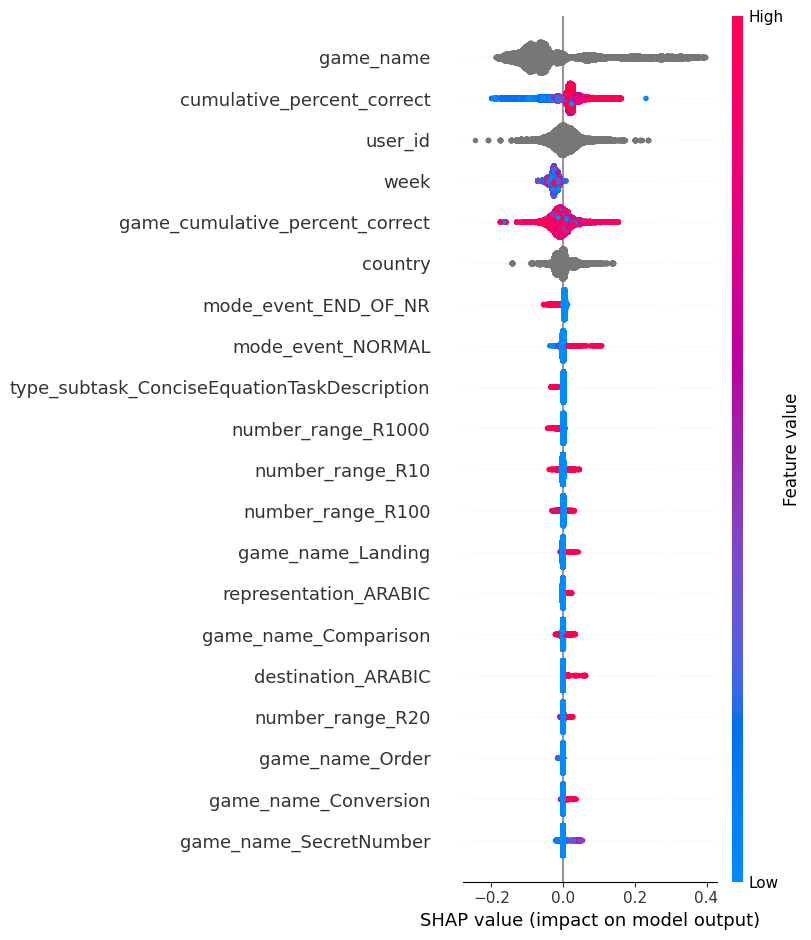

In [311]:
shap_values = shap.TreeExplainer(model).shap_values(test)
shap.summary_plot(shap_values, test)

(array([ 1368., 25213., 23525.,  8197.,  3549.,  1501.,   914.,   528.,
          506.,   257.]),
 array([-0.07012705,  0.03677468,  0.14367642,  0.25057816,  0.35747989,
         0.46438163,  0.57128337,  0.67818511,  0.78508684,  0.89198858,
         0.99889032]),
 <BarContainer object of 10 artists>)

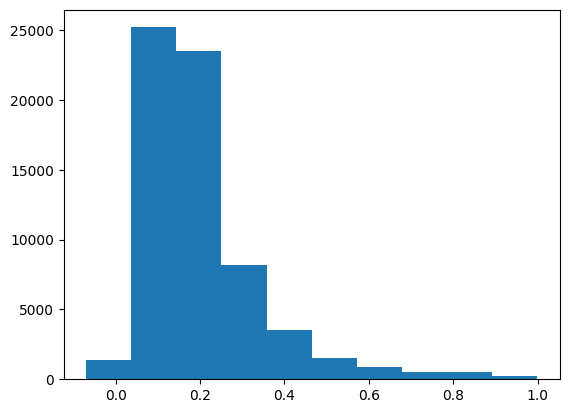

In [312]:
pred = model.predict(test)
plt.hist(pred)

(array([3.3635e+04, 1.7076e+04, 6.7410e+03, 3.3840e+03, 2.3220e+03,
        5.2700e+02, 6.3300e+02, 2.9000e+02, 1.3000e+01, 9.3700e+02]),
 array([0.00276243, 0.10248619, 0.20220994, 0.3019337 , 0.40165746,
        0.50138122, 0.60110497, 0.70082873, 0.80055249, 0.90027624,
        1.        ]),
 <BarContainer object of 10 artists>)

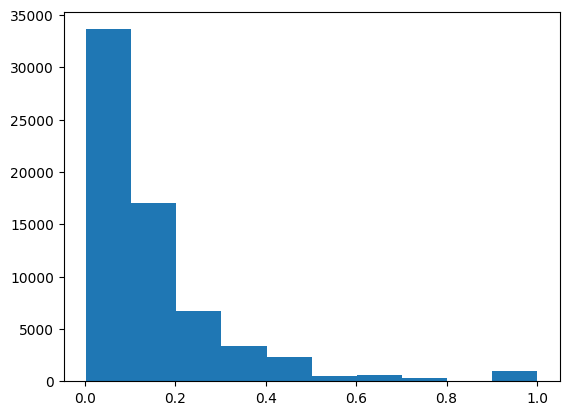

In [313]:
plt.hist(y_test[target_feature])

In [24]:
df.groupby("user_id")['week'].max()[df.groupby("user_id")['week'].max() > 30]

user_id
8       44
10     131
14      47
15      49
16     118
      ... 
903     68
908     46
912     43
917     33
918    113
Name: week, Length: 317, dtype: int32